In [124]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [125]:
%reset -f
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from datasets import *
from models import *
from transforms import *
from profiler import *

import seaborn as sns
sns.set(font_scale=1.5)

In [126]:
ds = WingbeatsDataset(dsname="/home/kalfasyan/Desktop/tmp/Suzukii_RL/", 
                verbose=False,
                custom_label=[1], 
                clean=False, 
                transform=transforms.Compose([Bandpass(lowcut=140, highcut=1500), 
                                            TransformWingbeat(setting='psdl2')]))

In [127]:
ds_raw = WingbeatsDataset(dsname="/home/kalfasyan/Desktop/tmp/Suzukii_RL/", 
                verbose=False,
                custom_label=[1], 
                clean=False, 
                transform=transforms.Compose([Bandpass(lowcut=140, highcut=1500)]))

In [128]:
def get_dataset_df(self, batch_size=16, height=0.04, prominence=0.001, width=1, distance=5):

    d = WingbeatsDataset(dsname=self.dsname, 
                        custom_label=[1], 
                        clean=False, 
                        transform=transforms.Compose([Bandpass(highcut=1500), 
                                                        NormalizedPSD(norm='l2', scaling='density', window='hanning', nfft=8192, nperseg=5000, noverlap=2500)]))

    dloader = DataLoader(d, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    sums,paths,labels,idx,peaks,peaksxtra = [],[],[],[],[], []
    time.sleep(.5)
    for x,l,p,i,_ in tqdm(dloader, total=len(d)//batch_size, desc='Collecting all data from the dataloader..'):
        paths.extend(p)
        idx.extend(i.numpy())
        labels.extend(l.numpy())
        for sig in x:
            sums.extend([sig.squeeze().sum()])
            p, _ = find_peaks(sig.squeeze(), height=height, prominence=prominence, width=width, distance=distance)
            peaks.extend([len(p)])
            peaksxtra.extend([p])

    print("Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..")        
    df = pd.DataFrame({"x": paths, "y": labels, "idx": idx, "score": torch.tensor(sums), "peaks": peaks, "peaksxtra": peaksxtra})
    print("Duration..")
    df['duration'] = df.x.apply(lambda x: get_wbt_duration(x, window=150, th=0.003))
    print("Sum..")
    df['sum'] = df.x.apply(lambda x: open_wingbeat(x).abs().sum().numpy())
    print("Max..")
    df['max'] = df.x.apply(lambda x: open_wingbeat(x).abs().max().numpy())
    print("Bad chunk score")
    df['badchunkscore'] = df.x.apply(lambda x: get_bad_first_chunk_score(open_wingbeat(x).squeeze().numpy()))
    print("Filename..")
    df['fname'] = df.x.apply(lambda x: x.split('/')[-1][:-4])
    self.df = df
    print('Finished.')
    return df

In [129]:
bandpass_low=140.
bandpass_high=1500.
rollwindow=150
noisethresh=0.003
rpiformat=False
custom_label=[1]
height=0.04
prominence=0.001
width=1
distance=5

df = get_dataset_df(ds)
# df = df.sort_values(by='fname')
# df.reset_index(inplace=True, drop=True)
# df.set_index('')

Found 6 in dataset: /home/kalfasyan/Desktop/tmp/Suzukii_RL/, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Finished.


100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


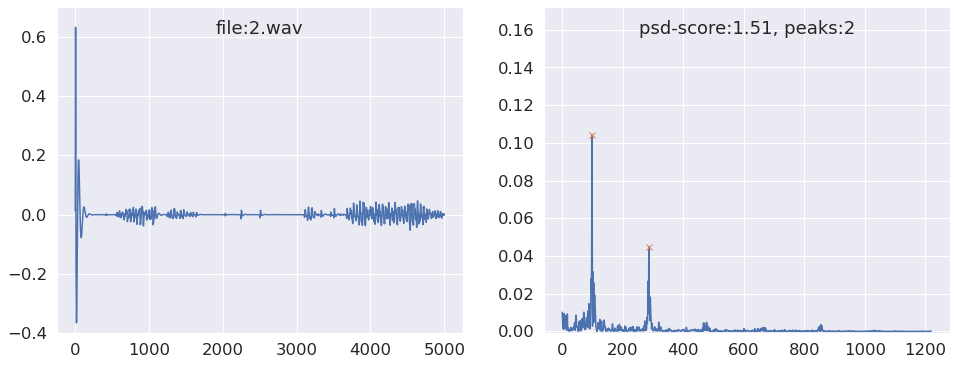

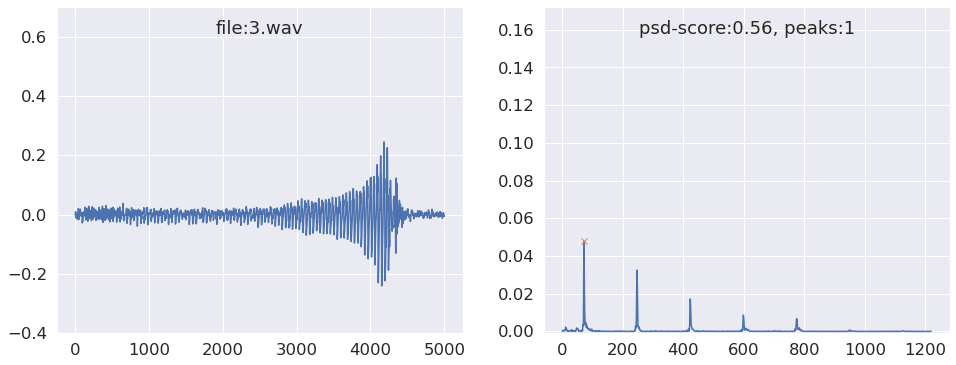

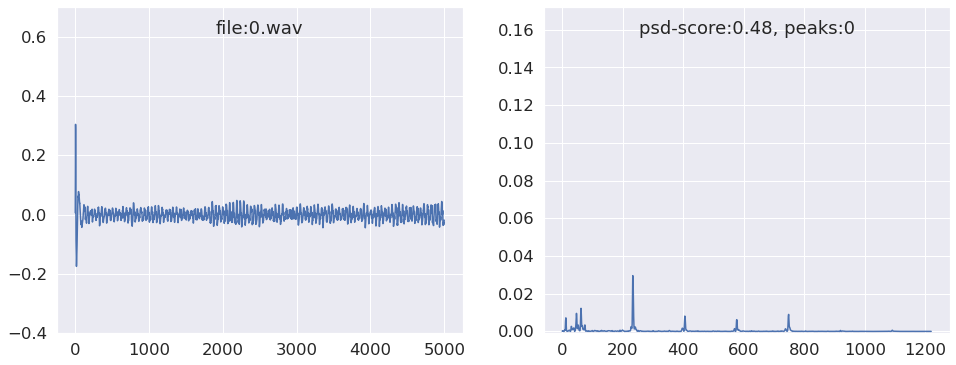

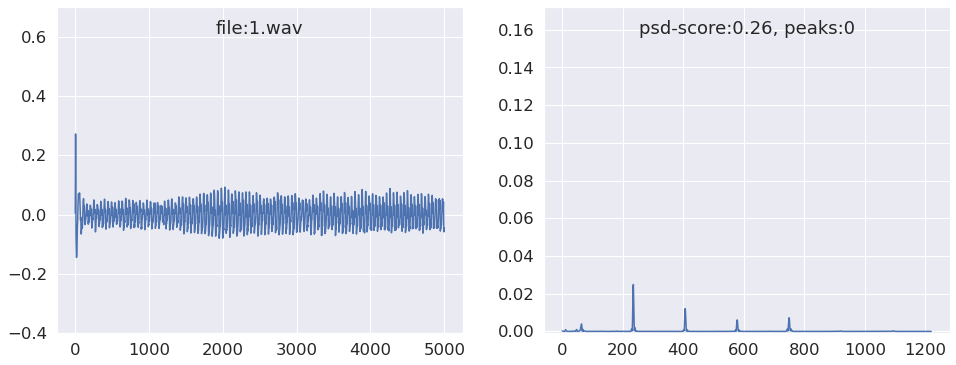

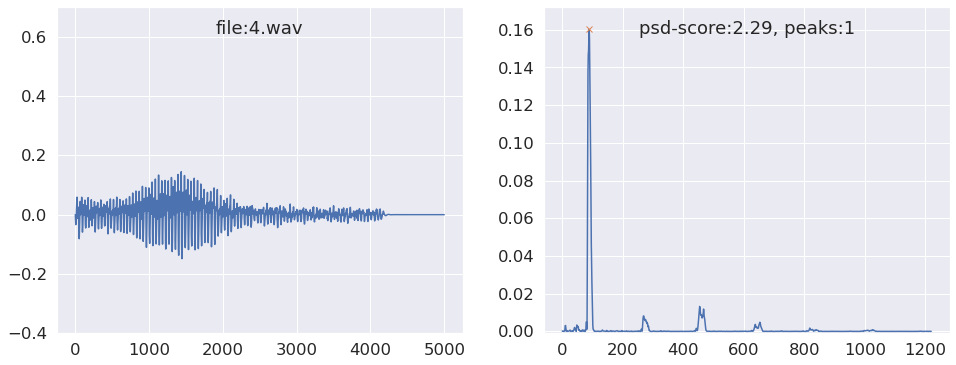

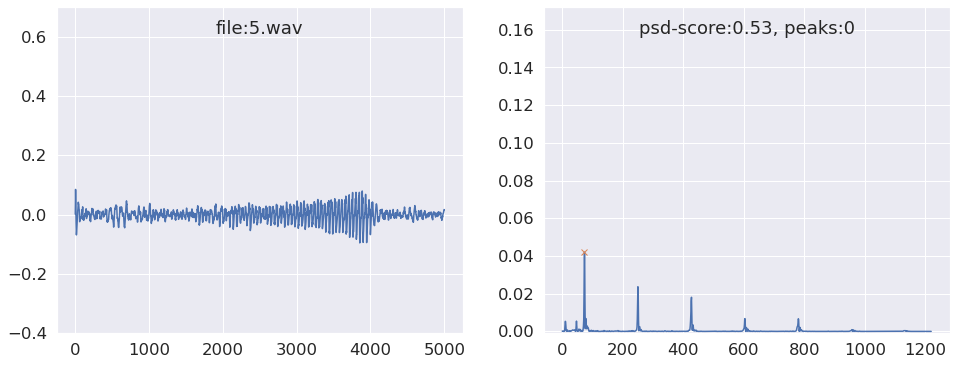

In [130]:
for i in tqdm(range(6)):
    
    plt.figure(figsize=(16,6))
    
    raw = ds_raw[i][0].squeeze()
    
#     score = df.loc[i].score
    duration = df.loc[i].duration
    filename = df.loc[i].x.split('/')[-1]
    
    plt.subplot(1,2,1)    
    plt.plot(raw)    
    plt.ylim(-.4,.7)

    plt.title(f"file:{filename}", y=.9)

    
    plt.subplot(1,2,2)
    sig = ds[i][0].squeeze()[140:1500]
    
    peaks, _ = find_peaks(sig, height=height, threshold=noisethresh, distance=5, prominence=prominence, width=width)
    peaks = len(peaks)
    
    score = sig.sum()

    show_peaks(sig);
#     plt.xticks(np.arange(140,1500))
    plt.ylim(-.001,.172)
    plt.title(f"psd-score:{score:.2f}, peaks:{peaks}", y=.9)
    
    plt.savefig(f"/home/kalfasyan/Desktop/tmp_{filename[:-4]}.png")

In [165]:
wbprof = WingbeatDatasetProfiler(dsname="/home/kalfasyan/Desktop/tmp/Suzukii_RL/", customformat=True)
wbprof.df

Found 6 in dataset: /home/kalfasyan/Desktop/tmp/Suzukii_RL/, and 1 label(s): ['D. suzukii']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Finished.


,x,y,idx,score,peaks,peaksxtra,duration,sum,max,badchunkscore,fname,date
0,/home/kalfasyan/Desktop/tmp/Suzukii_RL/2.wav,0,0,5.506437,8,"[162, 175, 183, 189, 194, 199, 378, 566]",255.3,4744.675293,0.999969,0.486699,2,NA
1,/home/kalfasyan/Desktop/tmp/Suzukii_RL/3.wav,0,1,2.994167,2,"[176, 352]",485.1,271.027405,0.332977,0.014578,3,NA
2,/home/kalfasyan/Desktop/tmp/Suzukii_RL/0.wav,0,2,2.830703,1,[171],485.1,2415.395020,0.677979,0.289863,0,NA
3,/home/kalfasyan/Desktop/tmp/Suzukii_RL/1.wav,0,3,2.276246,1,[172],485.1,2767.307373,0.758972,0.198210,1,NA
4,/home/kalfasyan/Desktop/tmp/Suzukii_RL/4.wav,0,4,5.059755,2,"[183, 369]",414.3,1903.078857,0.999969,0.083801,4,NA
5,/home/kalfasyan/Desktop/tmp/Suzukii_RL/5.wav,0,5,2.976712,2,"[176, 353]",485.1,914.662842,0.395966,0.082606,5,NA


100%|██████████| 6/6 [00:00<00:00, 33.69it/s]


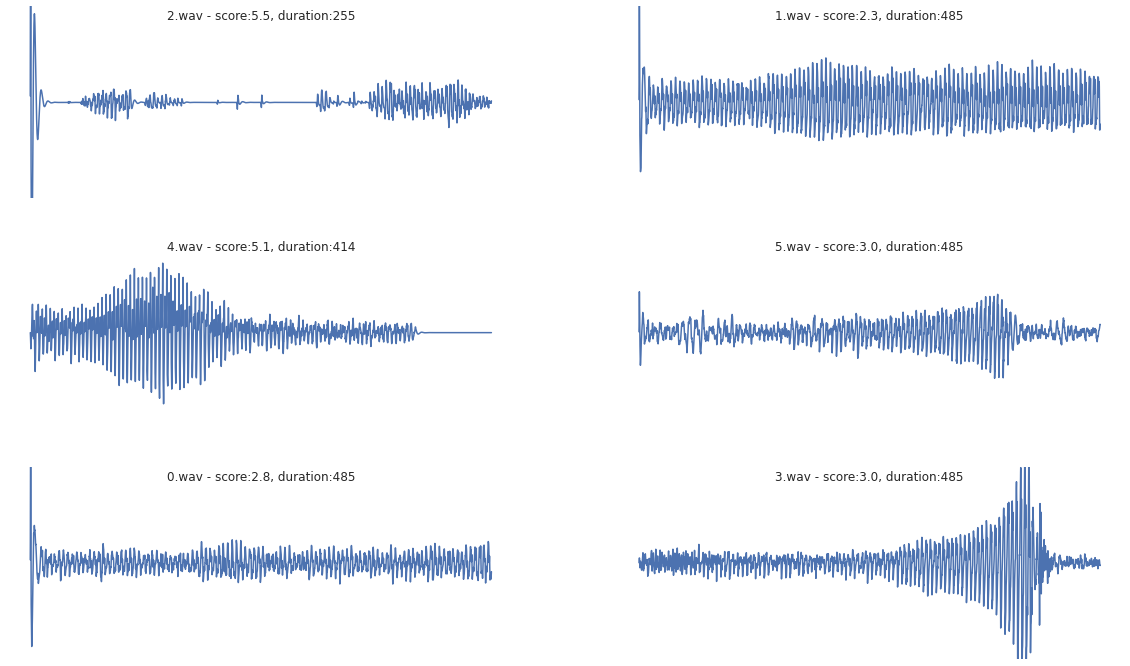

In [172]:
sns.set(font_scale=1.)
wbprof.plot_random_wbts(ylim=.2, subplot_x=3,subplot_y=2)

100%|██████████| 6/6 [00:00<00:00, 13.60it/s]


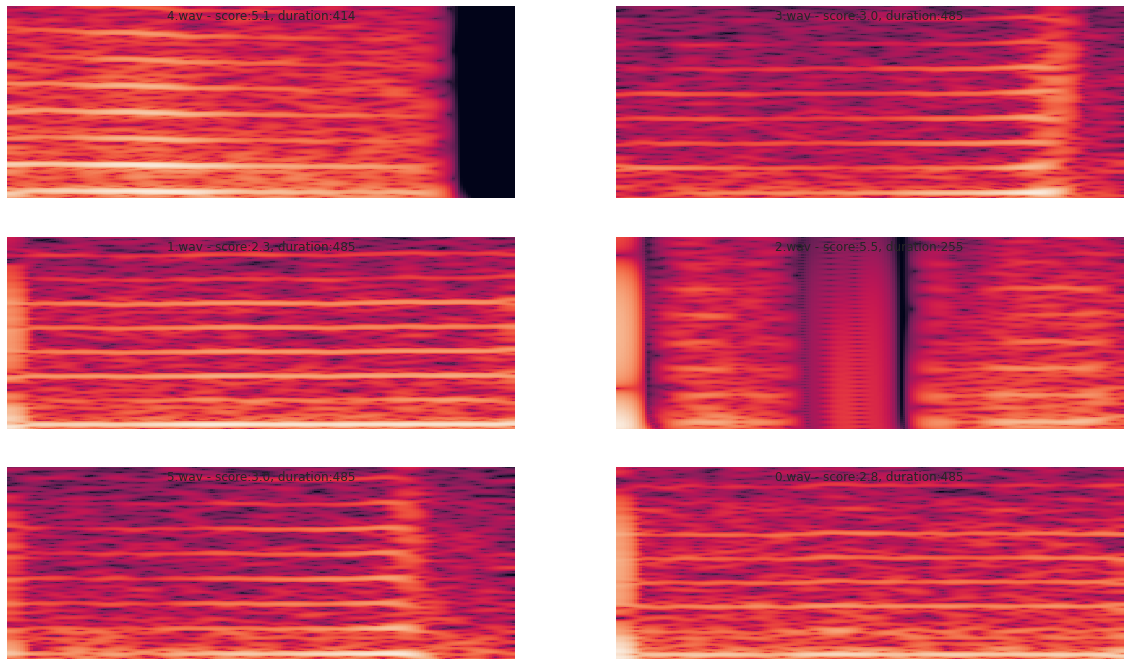

In [171]:
sns.set(font_scale=1.)
wbprof.plot_random_stfts(subplot_x=3,subplot_y=2)